In [16]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd
from skimage import io,img_as_float
import torch.optim as optim
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
import model_conv_bigger
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [18]:
source_folder = '/home/axtr7550/Chromosome_project/real_images/for_axel/'


In [19]:
image_coords = pd.read_csv(source_folder + 'fork_outputs/positions_df.csv')
with open(source_folder + 'fork_outputs/train_cell_masks.txt', 'r') as f:
    raw_image_names = f.readlines()
    


In [20]:
image_names = [name.strip().split('/')[-1] for  name in raw_image_names]
image_names = np.array(image_names) 
image_names

array(['Pos01_img_100.tif', 'Pos01_img_101.tif', 'Pos02_img_100.tif',
       'Pos02_img_101.tif', 'Pos03_img_100.tif', 'Pos03_img_101.tif',
       'Pos04_img_100.tif', 'Pos04_img_101.tif', 'Pos05_img_100.tif',
       'Pos05_img_101.tif', 'Pos06_img_100.tif', 'Pos06_img_101.tif',
       'Pos07_img_100.tif', 'Pos07_img_101.tif', 'Pos08_img_100.tif',
       'Pos08_img_101.tif', 'Pos09_img_100.tif', 'Pos09_img_101.tif',
       'Pos10_img_100.tif', 'Pos10_img_101.tif'], dtype='<U17')

In [21]:
image_coords['img_name'] = image_names[image_coords['Image'].values.astype(int)]

In [22]:
image_coords

,Image,x,y,img_name
0,0,101,407,Pos01_img_100.tif
1,0,103,380,Pos01_img_100.tif
2,0,106,465,Pos01_img_100.tif
3,0,111,527,Pos01_img_100.tif
4,0,114,615,Pos01_img_100.tif
...,...,...,...,...
6443,19,681,738,Pos10_img_101.tif
6444,19,684,723,Pos10_img_101.tif
6445,19,737,966,Pos10_img_101.tif
6446,19,820,675,Pos10_img_101.tif


In [23]:
images = torch.zeros((20, 1041, 1302))

for i in range(20):
    img = io.imread(f'{source_folder}pool/{image_names[i]}').astype(np.int16)
    images[i, ...] = torch.tensor(img)[img.shape[0]//2:]

torch.Size([1041, 1302])


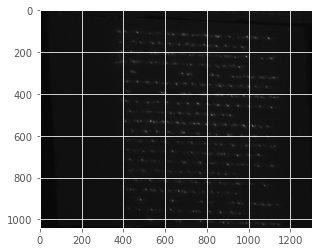

In [24]:
image = images[0]
plt.imshow(image, cmap='gray')
print(image.shape)


In [25]:
max_val , min_val = images.max(), images.min()

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
def final_loss(bce_loss, mu, logvar, beta=1):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

    return BCE + KLD*beta, BCE, KLD

In [28]:
def create_rois(image_coords, images):
    image_data = torch.tensor(image_coords[["Image", "x", "y"]].values, dtype=torch.int64)
    rois = torch.zeros((image_data.shape[0], 24, 24))
    
    for i in range(image_data.shape[0]):
        rois[i,:,:] = images[image_data[i,0], image_data[i,1]-12:image_data[i,1]+12, image_data[i,2]-12:image_data[i,2]+12]

    rois = rois/rois.max()
    return rois

In [29]:
def fit(model, rois, batch_size=128, beta=1):
    model.train()
    
    indeces = np.arange(rois.shape[0])
    np.random.shuffle(indeces)


    running_loss = 0.0
    for i in range(rois.shape[0]//batch_size):
        data = rois[indeces[i*batch_size:(i+1)*batch_size], ...]
        data = data.unsqueeze(1)
        data = data.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logvar, _ = model(data)
        bce_loss = criterion(reconstruction, data) # Reconstructs the noisy image
        loss, BCE, KLD = final_loss(bce_loss, mu, logvar, beta)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        save_mod = (1+1*epoch//10) if epoch < 100 else 10*(epoch//100)

        if (rois.shape[0]//batch_size - 1) and (epoch % save_mod == 0):
            num_rows = 8
            both = torch.cat((data.view(batch_size, 1, 24, 24)[:8], 
                                reconstruction.view(batch_size, 1, 24, 24)[:8]))
            save_image(both.cpu(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/VAE_real_beta{beta}_data_1_{epoch}.png", nrow=num_rows, pad_value=1)

    train_loss = running_loss/rois.shape[0]
    return train_loss

In [30]:
model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr=lr)
#criterion = nn.BCELoss(reduction='sum')
criterion = nn.MSELoss(reduction='sum')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.2,
                                                    patience=20,
                                                    min_lr=5e-5)


In [31]:
rois = create_rois(image_coords, images)
#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
scaling = rois.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
means = rois.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
stds = rois.std(dim=1, keepdim=True).mean(dim=2, keepdim=True)
scaling = torch.quantile(rois, 0.99)
rois = (rois - means)/(stds)
rois = rois.clamp(-1.5,1.5)
rois = rois*0.33333+0.5
rois = rois.clamp(0.0,1)

#rois = rois/scaling


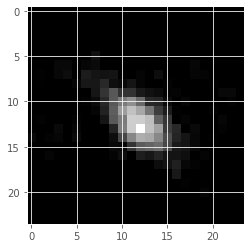

In [134]:
rois = create_rois(image_coords, images)
#scaling = torch.quantile(torch.quantile(rois, 0.95, axis=1, keepdim=True), 0.95, axis=1, keepdim=True)
means = rois.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
stds = rois.std(dim=1, keepdim=True).mean(dim=2, keepdim=True)
rois = (rois - means)/(stds)
rois = rois.clamp(0, 10)
rois = rois*1/10+0/10
rois = rois.clamp(0.0,1)



plt.imshow(rois[5], cmap='gray', vmin=0, vmax=1)

In [51]:
batch_size = 128


train_loss = []
for beta in [1]:
    curr = 0
    epochs = 5000

    
    model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
    lr = 0.001
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    #criterion = nn.BCELoss(reduction='sum')
    criterion = nn.MSELoss(reduction='sum')
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                        mode='min',
                                                        factor=0.2,
                                                        patience=20,
                                                        min_lr=5e-5)


    for epoch in range(curr, curr+epochs+1):
        print(f"Epoch {epoch+1} of {epochs}")
        train_epoch_loss = fit(model, rois, batch_size=batch_size, beta=beta)
        train_loss.append(train_epoch_loss)
        print(f"Train Loss: {train_epoch_loss:.4f}")
        if epoch % 5000 == 0:
            torch.save(model.state_dict(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_data_z_only_1_45deg_beta{beta}_{epoch}.pt")



Epoch 1 of 5000
Train Loss: 36.0656
Epoch 2 of 5000
Train Loss: 21.7894
Epoch 3 of 5000
Train Loss: 21.0810
Epoch 4 of 5000
Train Loss: 20.7257
Epoch 5 of 5000
Train Loss: 20.5696
Epoch 6 of 5000
Train Loss: 20.4853
Epoch 7 of 5000
Train Loss: 20.4263
Epoch 8 of 5000
Train Loss: 20.3399
Epoch 9 of 5000
Train Loss: 20.2919
Epoch 10 of 5000
Train Loss: 20.2253
Epoch 11 of 5000
Train Loss: 20.2323
Epoch 12 of 5000
Train Loss: 20.1460
Epoch 13 of 5000
Train Loss: 20.2141
Epoch 14 of 5000
Train Loss: 20.1519
Epoch 15 of 5000
Train Loss: 20.0499
Epoch 16 of 5000
Train Loss: 20.0337
Epoch 17 of 5000
Train Loss: 19.9843
Epoch 18 of 5000
Train Loss: 19.9742
Epoch 19 of 5000
Train Loss: 19.9362
Epoch 20 of 5000
Train Loss: 19.9263
Epoch 21 of 5000
Train Loss: 19.9018
Epoch 22 of 5000
Train Loss: 19.8598
Epoch 23 of 5000
Train Loss: 19.8345
Epoch 24 of 5000
Train Loss: 19.8387
Epoch 25 of 5000
Train Loss: 19.8380
Epoch 26 of 5000
Train Loss: 19.8329
Epoch 27 of 5000
Train Loss: 19.7716
Epoch 28 o

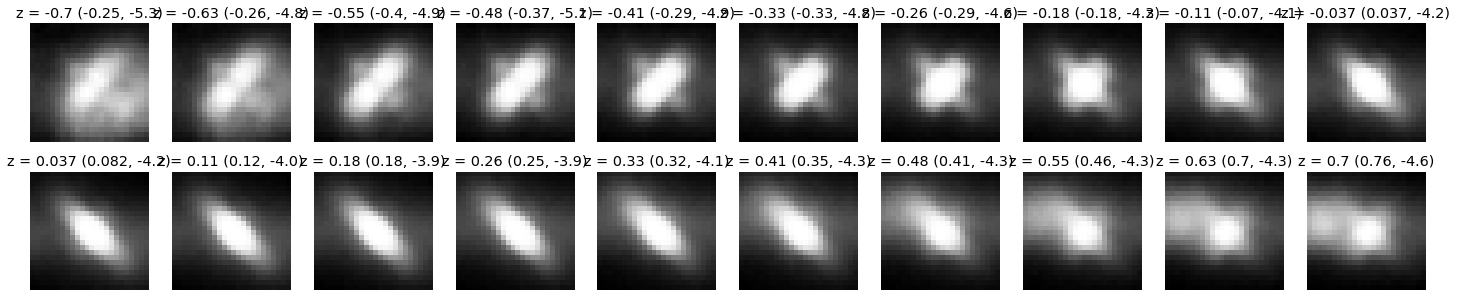

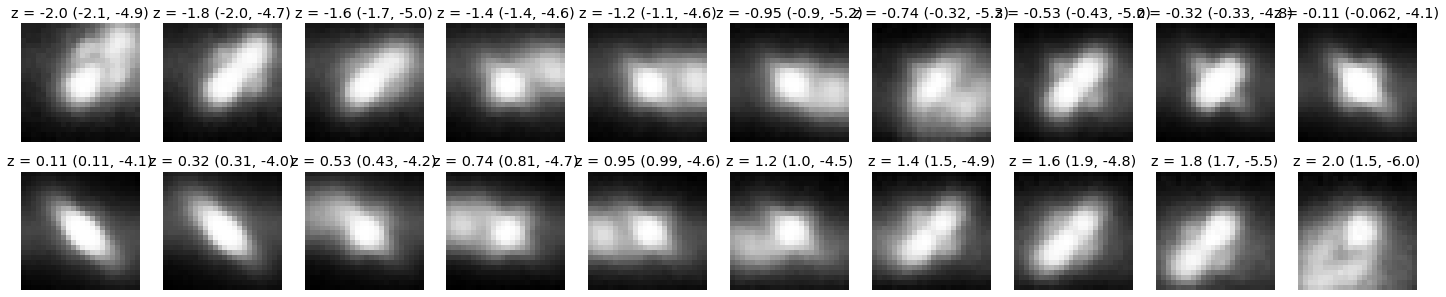

In [ ]:
model = model_conv_bigger.VAE_CNN_version_2_24x24(zDim=1).to(device)
model.load_state_dict(torch.load(f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/real_images/models/VAE_real_data_z_only_1_45deg_beta1_5000.pt"))

n_steps =20

xyz = torch.ones((n_steps,3))*32
zs = torch.linspace(-2, 2, n_steps).view(-1,1).to(device)

model.eval()

images = model.decoder(zs)
mus, logvar = model.encoder(images)
images = images.cpu().detach().numpy()

fig, axs = plt.subplots(2,10, figsize=(25,5))
for j in range(images.shape[0]):
    ax = axs[j//10][j%10]
    ax.imshow(images[j,0,...], cmap='gray')
    ax.axis('off')
    ax.set_title(f'z = {zs[j].item():.2} ({mus[j].item():.2}, {logvar[j].item():.2})')

#plt.savefig(f'/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/noisy/Resnet_B{beta}_nois2noise_noise{noise_scale}_VAE_z_45deg_{epoch}.png', transparent=False)


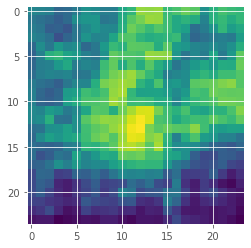

In [58]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

n_steps = 1000
zs = torch.linspace(-4, 4, n_steps).view(-1,1).to(device)

model.eval()

images = model.decoder(zs)
cpu_images = images.detach().to('cpu').numpy()
plt.imshow(cpu_images[0, 0,...])


In [ ]:
slider =widgets.IntSlider(
    min=0,
    max=rois.shape[0]-1,
    step=1,
    description='Slider:',
    value=3
)
btn = widgets.Button(description='Bad')



In [85]:
cpu_rois = rois.to('cpu').numpy()

model.eval()
rois = rois.to(device)
mu, logvar = model.encoder(rois.unsqueeze(1))
mu = mu.detach().cpu().numpy()

torch.Size([6448, 24, 24])


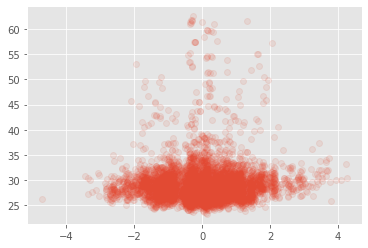

In [183]:


roi_base = create_rois(image_coords, images)
print(roi_base.shape)
intensity = roi_base.sum(axis=1).sum(axis=1)

plt.plot(mu,intensity , 'o', alpha=0.1)

In [201]:
out = widgets.Output(layout=Layout(width='70%', height='500px'))

def on_value_changed(val):
    with out:
        out.clear_output()
        i = slider.value
        image = cpu_rois[i,...]
        plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
        plt.axis('off')
        plt.show()
        
slider.observe(on_value_changed, names='value')

In [202]:
indeces_to_remove = []
roi_base = create_rois(image_coords, images)
intensity = roi_base.sum(axis=1).sum(axis=1)

def on_button_click(b):
    with out:
        plt.plot(mu,intensity , 'o', alpha=0.05)
        plt.plot(mu[slider.value],intensity[slider.value], 'bo', alpha=1)
        plt.show()

btn.on_click(on_button_click)


In [203]:
display(out)
display(btn)
display(slider)


Output(layout=Layout(height='500px', width='70%'))

Button(description='Bad', style=ButtonStyle())

IntSlider(value=3, description='Slider:', max=6001)

In [188]:
slider_latent =widgets.IntSlider(
    min=0,
    max=999,
    step=1,
    description='Slider:',
    value=3
)
#btn = widgets.Button(description='Bad')

out_latent = widgets.Output(layout=Layout(width='70%', height='300px'))

def on_latent_value_changed(val):
    with out_latent:
        out_latent.clear_output()
        i = slider_latent.value
        image = cpu_images[i,0,...]
        plt.imshow(image, cmap='gray', vmin=0.0, vmax=1.0)
        plt.axis('off')
        plt.show()
        
slider_latent.observe(on_latent_value_changed, names='value')


In [54]:
display(out_latent)
display(slider_latent)


type: name 'out_latent' is not defined